# Generate wine tasting descriptions

In this notebook we're going to train an LSTM to generate wine tasting descriptions. 

In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace

import pandas as pd
import torch

from modules import config
from modules import model
from modules import train
from modules import utils

In [3]:
flags = Namespace(
    batch_size=128, # batch size
    drop_prob = 0.05, # dropout probability
    embedding_size=300, # glove vector dimension -- use 300
    gradients_norm=5, # norm to clip gradients
    learning_rate=0.001,
    lstm_size=300, # LSTM hidden size
    min_count=10, # do not use tokens with <= min_count occurences in corpus
    num_epochs=5, # epochs for which to train
    num_layers=3, # layers in the LSTM
    seq_size=50, # sequence length
    top_k=5, # top k results to sample word from
    )

### Load dataset

Our data comes from two sources:
    1. The SAQ website via a scraper that I coded (for those outside of Quebec: the SAQ is a government-owned Crown corporation and monopoly that is responsible for the trade of alcoholic beverages within the province).
    2. The Kaggle "Wine Reviews" dataset (https://www.kaggle.com/zynicide/wine-reviews) scrapped from the Wine Enthusiast website

We will load the data and view a few samples of real wine descriptions

In [4]:
col_names = ['wine', 'tasting notes', 'pairings', 'country', 'region', 'producer', 'grape varieties', 'colour', 'alcohol %', 'sugar (g/L)', 'tint', 'intensity', 'aromas', 'flavours', 'price (CAD)']
df_saq = pd.read_csv(config.SAQ_DATA, sep = '*', header = None, names=col_names).dropna(subset=['tasting notes'])

df_winemag = pd.read_csv(config.WE_DATA, encoding="utf-8")
df_winemag = df_winemag.drop(df_winemag.columns[0],axis=1)

df = pd.concat([df_saq['tasting notes'], df_winemag['description']]).to_frame("description")
pd.set_option('display.max_colwidth', None)
df[:3]

,description
1,"Cherry-red in colour, this red boasts a medium nose exuding woody, floral and fruity aromas. Discover this medium-bodied wine expressing light acidity and offering a full-bodied texture and fleshy tannins. It also unveils a medium mouthfeel that leads into a medium finish."
4,"This dry purplish red coloured wine features medium woody, empyreumatic, spicy, fruity and vegetal scents and offers a broad texture as well as firm tannins."
6,"This dry and purplish red coloured red showcases a simple nose releasing woody, spicy and fruity scents. You will be charmed with this medium-bodied wine revealing a broad texture, smooth tannins and a medium finish."


In [5]:
print("There are %d wine tasting decriptions in our dataset" % df.shape[0])

There are 133235 wine tasting decriptions in our dataset


### Prepare data for training

- Tokenize the corpus of documents (wine descriptions)
- Make dicts converting tokens to unique ints and those same ints to tokens
- Make training set --> n-grams from tokenized documents

In [6]:
tokenized_corpus = utils.tokenize(df)

In [7]:
token_to_num, num_to_token = utils.word_to_int(tokenized_corpus, flags.min_count)

In [8]:
X, Y, seeds = utils.make_training_set(tokenized_corpus, flags.seq_size, token_to_num)

### Train or load a model

In [9]:
from_scratch = False # if True, train model from scratch. If False, load saved model specified in config file

if from_scratch:
    date = utils.datenow()
    device = torch.device('cpu')
    net = model.RNNModule(flags.lstm_size, config.GLOVE, token_to_num, flags.embedding_size, 
                          flags.num_layers, flags.drop_prob)
    net = net.to(device)
    net, train_losses = train.train(flags.learning_rate, flags.num_epochs, X, Y, flags.batch_size, net, flags.gradients_norm,  
                token_to_num, seeds, num_to_token, flags.top_k)
    train.save_model(net, train_losses, config.DATA_ROOT+date+"_lr"+flags.learning_rate+
                     "_e"+flags.num_epochs+"_bs"+flags.batch_size+"_gn"+flags.gradients_norm+
                     "_drop"+flags.drop_prob+"_size"+flags.lstm_size+
                     "_embed"+flags.embedding_size+"_seq"+flags.seq_size+
                     "min"+flags.min_count+"_k"+flags.top_k+"_wine_generator.pt")
else:
    net, train_losses = train.load_model(config.MODEL, config.LOSSES, token_to_num)    

### Plot a learning curve

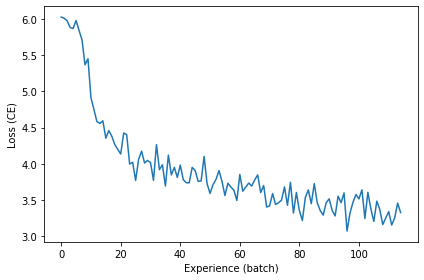

In [10]:
fig = utils.learning_curve(train_losses)

Loss decreases with experience and seems to be at or near a stable plateau.

### Generate wine tasting descriptions

In [11]:
utils.predict(net, token_to_num, num_to_token, 0, seeds, flags.top_k)

'A crisp blend of 50% sangiovese, 35% grenache, 10% cabernet franc and 5% petit verdot. The palate is full and round, with firm backbone of tannins and bright acidity.'

A few examples:

'A blend of cabernet sauvignon and petit verdot. The aromas are quite locked up, with notes of black cherry, raspberry, tobacco and a whiff of new leather. The palate is full and round, with firm tannins and bright acidity.'

'This is a big, full-bodied wine. The tannins are quite present, but it's not too tannic. It's a bit awkward, but the finish is full of ripe, jammy black fruits, with a hint of smoke.'

'Firm and stalky, with notes of smoke and black pepper. The palate is full and round, with chewy texture. Flavors of blackberry, plum and cassis finish with a touch of vanilla and spice.'

'Sharp cinnamon and a whiff of leather come together on this full-bodied wine. The palate is full and round, with firm tannins and fresh acidity. Flavors of blackberry, plum and chocolate are a bit lean and tannic, but blunt.'

"This has flavors of ripe blackberry, black currant, licorice and sweet, smoky oak. It's a bit hot and tannic, with a long, spicy finish. It's a big wine, packed with fruit and tannins, with a rich, creamy texture."

"Shows the problems of the vintage, it's a bit sharp and tannic, with a light, spicy finish. The wine is dry and silky, with a rich core of blackberry jam, black cherry and currant."

'Yellow wildflower and 40% merlot, this wine is a bit shy and more austere. The nose is light and fresh, with a long, silky texture.'